<a href="https://colab.research.google.com/github/gh-yana/testing1/blob/master/yana_testing_sklearn_1_LinearRegression_TokyoPower_Sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# scikit-learn(sklearn)で東京電力の電力需要を重回帰予測する
## ～ReNom RG＜ Graph-CNN モデル＞と重回帰の比較実験～

### 本例で用いる学習データの所在

*   **東京電力「過去の電力使用実績のダウンロード」**[ここから入手](http://www.tepco.co.jp/forecast/html/download-j.html)
*   **気象庁「過去の気象データ・ダウンロード」**[ここから入手](https://www.data.jma.go.jp/gmd/risk/obsdl/index.php)


### GoogleドライブからColaboratoryへのデータコピー（事前準備）

In [0]:
!!pip install -U -q PyDrive

In [0]:
# Google Driveアクセス準備
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Google Driveからのコピー
id = '1rVv9OxeT66N_tTz8IJ1IjSjwkJU46G7U'  # 共有リンクで取得した id= より後の部分
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('Tokyo_Power_weather_2017-2018_sample_new2.csv')
id = '1trUd87JbzwiE5Mu4ui_3xX7koyGFLhBK'  # 共有リンクで取得した id= より後の部分
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('Tokyo_Power_weather_Predict_sample_new2.csv')
# 終わったら、ファイル画面の更新をして確認

### データ準備

学習データの準備

本例では2017/1/1～2018/12/31の東京電力_電力実績と気象庁データ(気温/降水量/日照時間/風速など)の結合データ(CSV)を使用

　データフレーム名　**train_df** ：Tokyo_Power_Weather_2017-2018_sample_new2.csvをPandasで格納

In [0]:
import pandas as pd #pandasをpdとしてインポート。データをdfに読み込み。pandasをpdとして利用。
train_df = pd.read_csv("Tokyo_Power_weather_2017-2018_sample_new2.csv", encoding="utf_8")
train_df.head(5)    #データフレームの表示（先頭5行表示）

,DATE,TIME_hh,TIME_mm,Man_kW,Temp_C,Sun_h,Wind_m_par_S,Rain_mm
0,2017/1/1,1,0,2634,5.1,0.0,3.5,0.0
1,2017/1/1,2,0,2520,4.1,0.0,1.7,0.0
2,2017/1/1,3,0,2438,4.0,0.0,1.5,0.0
3,2017/1/1,4,0,2389,3.0,0.0,1.0,0.0
4,2017/1/1,5,0,2394,3.6,0.0,2.2,0.0


【参考】データサンプルのカラム説明（レコード数は17,506） 

**DATE**:年月日(東電)、**TIME_hh**:時間(東電)、**TIME_mm**:分(東電)、**Man_kW**:電力量　万キロワット(東電)**←今回の目的変数**、

**Temp_C**:気温　℃(気象庁)、**Sun_h**:日照時間　時間(気象庁)、**Wind_m_par_S**:風速　m/秒(気象庁)、**Rain_mm**:降水量　mm(気象庁)


In [0]:
# 不要カラムの削除（今回はDATEとTIME_mmを削除）
train_df = train_df.drop("DATE",axis=1)
train_df = train_df.drop("TIME_mm",axis=1)
train_df.head(5)    #不要カラム削除後のデータフレーム表示（先頭5行表示）

,TIME_hh,Man_kW,Temp_C,Sun_h,Wind_m_par_S,Rain_mm
0,1,2634,5.1,0.0,3.5,0.0
1,2,2520,4.1,0.0,1.7,0.0
2,3,2438,4.0,0.0,1.5,0.0
3,4,2389,3.0,0.0,1.0,0.0
4,5,2394,3.6,0.0,2.2,0.0


In [0]:
# 説明変数Ｘの準備
X = train_df
X = X.drop("Man_kW", axis=1)    # 目的変数のMan_kWを削除
print(X.describe())   # Ｘの概要（最大値/標準偏差/最小値等々）

            TIME_hh        Temp_C         Sun_h  Wind_m_par_S       Rain_mm
count  17506.000000  17506.000000  17506.000000  17506.000000  17506.000000
mean      11.503713     16.349360      0.237770      2.918565      0.164258
std        6.923247      8.477713      0.389792      1.507695      0.912790
min        0.000000     -3.600000      0.000000      0.000000      0.000000
25%        6.000000      9.000000      0.000000      1.800000      0.000000
50%       12.000000     16.700000      0.000000      2.600000      0.000000
75%       18.000000     23.100000      0.400000      3.700000      0.000000
max       23.000000     37.400000      1.000000     15.300000     20.500000


In [0]:
X.head(5)  # Ｘの表示（先頭5行）

,TIME_hh,Temp_C,Sun_h,Wind_m_par_S,Rain_mm
0,1,5.1,0.0,3.5,0.0
1,2,4.1,0.0,1.7,0.0
2,3,4.0,0.0,1.5,0.0
3,4,3.0,0.0,1.0,0.0
4,5,3.6,0.0,2.2,0.0


In [0]:
# 目的変数Ｙの準備
Y = train_df    # 元のtrain.dfからMan_kW以外を削除
Y = Y.drop("TIME_hh",axis=1)
Y = Y.drop("Temp_C",axis=1)
Y = Y.drop("Sun_h",axis=1)
Y = Y.drop("Wind_m_par_S",axis=1)
Y = Y.drop("Rain_mm",axis=1)
Y.head(5)   # Ｙの表示（先頭5行）

,Man_kW
0,2634
1,2520
2,2438
3,2389
4,2394


学習データ（テスト含む）のＸ(説明変数)とＹ(目的変数)の準備完了。

### 重回帰モデル作成

In [0]:
import pandas as pd    # 必要なライブラリのインポート
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split   # 学習とテストのデータを分割する時に必要
from sklearn import datasets
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# 学習用とテスト用のデータ分割
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.8, random_state=0)   # 学習用80％、テスト用20％に分割

# 重回帰分析（予測モデルの作成）
clf = linear_model.LinearRegression(fit_intercept=True, normalize=True, copy_X=True, n_jobs=1)
clf.fit(X_train, Y_train)

#print(pd.DataFrame({"Name":X.columns,"Coefficients":np.abs(clf.coef_)}).sort_values(by='Coefficients'))
print("回帰変数：",clf.coef_)    # coef　：回帰変数
print("切片：",clf.intercept_)    # intercept_ ：切片
#print("決定係数(学習用)：",clf.score(X_train,Y_train))   # score ：決定係数 R2を出力
#print("決定係数(テスト用)：",clf.score(X_test,Y_test))   # score ：決定係数 R2を出力

回帰変数： [[ 41.68111068  -4.81237872 440.17305855  36.94520187 -11.17360726]]
切片： [2694.84862232]
決定係数(学習用)： 0.2895613071277868
決定係数(テスト用)： 0.26832504661427914


重回帰モデルの作成完了。

結果を式で表すと　Man_kW = (41.68 * TIME_hh) + (-4.81 * Temp_C) + (440.17 * Sun_h) + (36.94 * Wind_m_par_S) +(-11.17 * Rain_mm) +2694.84

### Prediction

予測データの準備

本例では2019/4/1～4/5の東京電力_電力実績と気象庁データ(気温/降水量/日照時間/風速など)の結合データ(CSV)を、将来データとして使用

　データフレーム名　**pred_df** ：Tokyo_Power_weather_Predict_sample_new2.csvをPandasで格納

In [0]:
# 予測用データの準備
pred_df = pd.read_csv("Tokyo_Power_weather_Predict_sample_new2.csv", encoding="utf_8")
pred_df.head(5)    #  データフレームの表示（先頭5行）

,DATE,TIME_hh,TIME_mm,Temp_C,Sun_h,Wind_m_par_S,Rain_mm
0,2019/4/1,1,0,8.2,0.0,3.3,0.0
1,2019/4/1,2,0,7.8,0.0,4.1,0.0
2,2019/4/1,3,0,7.3,0.0,2.4,0.0
3,2019/4/1,4,0,7.1,0.0,4.1,0.0
4,2019/4/1,5,0,6.7,0.0,1.8,0.0


In [0]:
# 不要カラムの削除（今回はDATEとTIME_mmを削除）
X2 = pred_df
X2 = X2.drop("DATE",axis=1)
X2 = X2.drop("TIME_mm",axis=1)
X2.head(5)    #不要カラム削除後のデータフレーム表示（先頭5行表示）

,TIME_hh,Temp_C,Sun_h,Wind_m_par_S,Rain_mm
0,1,8.2,0.0,3.3,0.0
1,2,7.8,0.0,4.1,0.0
2,3,7.3,0.0,2.4,0.0
3,4,7.1,0.0,4.1,0.0
4,5,6.7,0.0,1.8,0.0


In [0]:
# 予測の実施
pred = pred_df
rslt = clf.predict(X2)  # 重回帰予測値(目的変数 Y)を取得
pred['Pred_Man_kW'] = np.array(rslt)  # 予測基データ(説明変数 X)のデータフレームに、重回帰予測値(目的変数 Y)をカラム追加
pred.head(10)   # 予測結果を表示（先頭10件）

,DATE,TIME_hh,TIME_mm,Temp_C,Sun_h,Wind_m_par_S,Rain_mm,Pred_Man_kW
0,2019/4/1,1,0,8.2,0.0,3.3,0.0,2818.987394
1,2019/4/1,2,0,7.8,0.0,4.1,0.0,2892.149617
2,2019/4/1,3,0,7.3,0.0,2.4,0.0,2873.430074
3,2019/4/1,4,0,7.1,0.0,4.1,0.0,2978.880504
4,2019/4/1,5,0,6.7,0.0,1.8,0.0,2937.512602
5,2019/4/1,6,0,6.6,0.3,3.4,0.0,3170.839191
6,2019/4/1,7,0,8.0,1.0,2.3,0.0,3473.264390
7,2019/4/1,8,0,8.7,0.7,4.7,0.0,3468.193403
8,2019/4/1,9,0,11.0,0.8,2.4,0.0,3457.849384
9,2019/4/1,10,0,13.2,1.0,2.2,0.0,3569.588833


【参考】カラム説明 

**DATE**:年月日、**TIME_hh**:時間、**TIME_mm**:分、**Temp_C**:気温 ℃、**Sun_h**:日照時間 時間、

**Wind_m_par_S**:風速 m/秒、**Rain_mm**:降水量 mm、

**Pred_Man_kW**:電力量 万キロワット**←今回の目的変数**


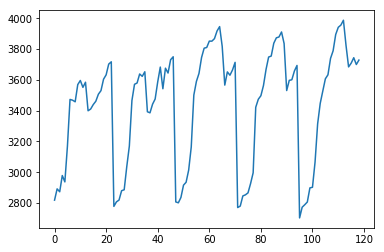

In [0]:
import matplotlib.pyplot as plt
y = np.array(rslt)  # 電力予測値をYにセット
x = np.array(range(119))  # X用に119個までの連番生成
plt.plot(x,y)
plt.show()

In [0]:
pred.to_csv("Tokyo_Power_Prediction_result.csv.csv")   # CSV出力

**重回帰予測とCSV保存が完了。**

### （その他）メモ書きなど

---